# Validating the use of Random Forest for WW Cross-section Measurement ( alt)

In [2]:
run prep_ana.py

loading data frame named df.
finished loading data frame
unc_mc_process and scales are dictionaries
scale_data = (5.27/19.7)


In [1]:
%matplotlib inline

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [3]:
#load root files
df_WW = rp.read_root("data/WW_tot_complete.root", "trees_vec")
df_DY = rp.read_root("data/DY_ll_complete.root", "trees_vec")
df_TT = rp.read_root("data/TT_ll_complete.root", "trees_vec")

df = pd.concat( [df_WW, df_TT, df_DY] )
df = df.reset_index()

In [4]:
train_WW = df[df.process=="WW"].sample( n=50000 )
train_DY = df[df.process=="DY"].sample( n=70000 )
train_TT = df[df.process=="TT"].sample( n=33000 )
train = pd.concat( [train_WW, train_DY, train_TT] )

test = df.drop( train.index )
print train.shape, test.shape

(153000, 59) (4884769, 59)


In [15]:
#features = ['nBJet', 'numb_jets', 'lep1_pt', 'lep2_pt', 'METProj', 'METProj_trk_sin', 'qT', 'mll', 'metMod', 'dPhiLLMET', 'dPhiLLJet', 'HT', 'lep_Type', 'mllMET', 'recoil' ] +\
#            ['jetPt'+str(i) for i in range(1,3)] + [ 'jet'+str(i)+'_csv' for i in range(1,3) ]
features = ['nBJet', 'numb_jets', 'lep1_pt', 'lep2_pt', 'METProj', 'qT', 'mll', 'metMod', 'dPhiLLMET', 'HT', 'lep_Type'] +\
            ['jetPt'+str(i) for i in range(1,7)]

# RF

In [6]:
#labels
labels = np.empty( train.shape[0] )
weights = np.empty( train.shape[0])

labels[(train.process == "WW").as_matrix()] = 1
labels[(train.process == "DY").as_matrix()] = 2
labels[(train.process == "TT").as_matrix()] = 2

weights[(train.process == "WW").as_matrix()] = 1.
weights[(train.process == "DY").as_matrix()] = 1
weights[(train.process == "TT").as_matrix()] = 1

In [16]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100, n_jobs=-1, min_samples_split=10, max_depth=15, max_features='sqrt')
clf = clf.fit( np.float32(train[features].values) , np.float32(labels), sample_weight=weights)

In [17]:
print clf.score(np.float32(train[features].values), np.float32(labels), weights)

0.944647058824


In [18]:
#labels and weights
df_labels = np.empty( df.shape[0] )
df_weights = np.empty( df.shape[0])

df_labels[(df.process == "WW").as_matrix()] = 1
df_labels[(df.process == "DY").as_matrix()] = 2
df_labels[(df.process == "TT").as_matrix()] = 2

df_weights[(df.process == "WW").as_matrix()] = 1.
df_weights[(df.process == "DY").as_matrix()] = 1
df_weights[(df.process == "TT").as_matrix()] = 1

print clf.score(np.float32(df[features].values), np.float32(df_labels), df_weights)

0.943190130393


In [19]:
pred = clf.predict_proba(np.float32(test[features].values))

test["pred_WW"] = pred[:,0]
test["pred_DY"] = pred[:,1]
test["pred_TT"] = pred[:,1]

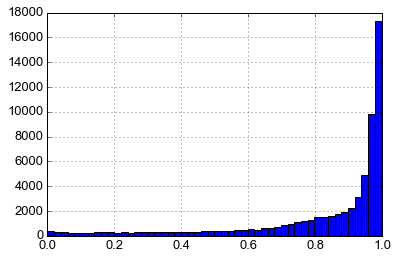

In [11]:
test[ (test.process == "WW") ].pred_WW.hist( bins= 50 )

In [20]:
cut = 0.969
feature_cuts =  (test.pred_WW > cut) & (test.numbExtraLep == 0) #& (test_df.qT > 0) & ()
feature_cuts_diff =( test.lep_Type > 0 ) & feature_cuts
feature_cuts_same = (test.lep_Type < 0) & feature_cuts
print "\tdiff", "\tsame"
for process in scales.keys():
    if process in test.process.unique():
        print process, test[ (test.process == process) & feature_cuts_diff].shape[0] * scales[process] * float(df[df.process == process].shape[0])/float(test[test.process == process].shape[0]),\
    test[ (test.process == process) & feature_cuts_same].shape[0] * scales[process] * float(df[df.process == process].shape[0])/float(test[test.process == process].shape[0])

	diff 	same
WW 3750.4042939 1216.39852014
DY 833.203490953 812.198360929
TT 302.825677091 91.0334857514


In [29]:
df_DY.sample( frac=.05).shape

(164657, 58)

In [14]:
train[train.process == "DY"].shape

(102240, 59)